In [36]:
import polars as pl
import matplotlib.pyplot as plt
pl.__version__

'0.19.13'

In [3]:
df = pl.scan_csv("TA.csv", try_parse_dates=True)

In [4]:
df.limit(0).collect().schema

OrderedDict([('NAME', Utf8),
             ('Date', Date),
             ('Median_SP', Float64),
             ('Median_SP_Real', Float64),
             ('Fisher_PI', Float64),
             ('Quantity', Int64),
             ('Stock', Int64),
             ('Quantity_Stock', Float64),
             ('spar_chained', Float64),
             ('spar_chained_land', Float64),
             ('LV_CV_mean', Float64),
             ('LV_mean', Float64),
             ('Geomean_Rent', Int64),
             ('Geomean_Rent_Real', Float64),
             ('Rent_Fisher_PI', Float64),
             ('Rent_ratio', Float64),
             ('HAM_Buy', Float64),
             ('HAM_Rent', Float64)])

In [35]:
akl = (
    df  .select(['NAME', 'Date', 'Median_SP'])
        .filter(pl.col('NAME') == 'Auckland')
        .drop_nulls()
        .group_by(pl.col('Date').dt.year())
        .agg(
            pl.col('NAME').first().alias("Region"), 
            pl.col('Median_SP').mean().round().alias('Median_Price'), 
            pl.col('Median_SP').count().alias('Observations')
        )
    )

chch = (
    df  .select(['NAME', 'Date', 'Median_SP'])
        .filter(pl.col('NAME') == 'Greater Christchurch')
        .drop_nulls()
        .group_by(pl.col('Date').dt.year())
        .agg(
            pl.col('NAME').first().alias("Region"), 
            pl.col('Median_SP').mean().round().alias('Median_Price'), 
            pl.col('Median_SP').count().alias('Observations')
        )
    )


aklchch = (
    akl .select(['Date'])
        .join(akl.select(['Date', 'Median_Price']), on='Date')
        .join(chch.select(['Date', 'Median_Price']), on='Date', suffix='_Chch')
        .rename({'Median_Price': 'Median_Price_Akl'})
        .with_columns((100* pl.col('Median_Price_Chch') / pl.col('Median_Price_Akl')).round().alias('Ratio'))
        .sort(by="Date")
)

res = aklchch.collect()
res

Date,Median_Price_Akl,Median_Price_Chch,Ratio
i32,f64,f64,f64
1993,141250.0,116750.0,83.0
1994,164750.0,126250.0,77.0
1995,183375.0,131375.0,72.0
1996,221500.0,139250.0,63.0
1997,231750.0,147352.0,64.0
1998,228250.0,149788.0,66.0
1999,229375.0,154625.0,67.0
2000,232500.0,155000.0,67.0
2001,240500.0,156688.0,65.0


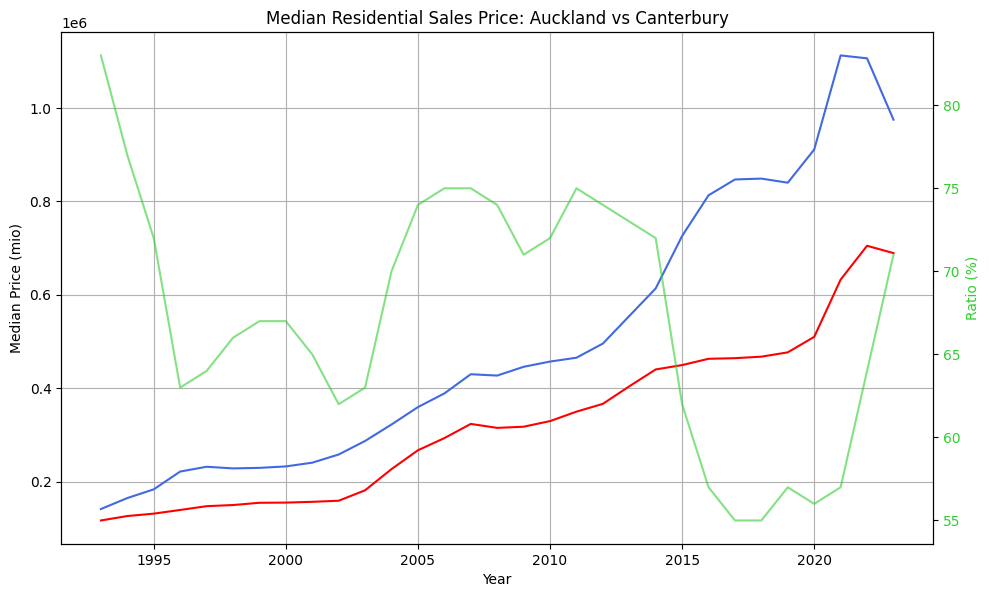

In [66]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color0 = 'black'
color1 = 'royalblue'
color2 = 'red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Median Price (mio)', color=color0)
ax1.plot(res['Date'], res['Median_Price_Akl'], color=color1)
ax1.plot(res['Date'], res['Median_Price_Chch'], color=color2)
ax1.tick_params(axis='y', labelcolor=color0)
plt.grid(True)

ax2 = ax1.twinx()
color3 = 'limegreen'
ax2.set_ylabel('Ratio (%)', color=color3)
ax2.plot(res['Date'], res['Ratio'], color=color3, alpha=0.6)
ax2.tick_params(axis='y', labelcolor=color3)

fig.tight_layout()
plt.title("Median Residential Sales Price: Auckland vs Canterbury")
plt.show()